# Chapter 10: Ensemble methods and decision tree

### 10.1. Decision tree
> ###### 10.1.1. Decision tree classifier
> ###### 10.1.2. Decision tree regressor
> ###### 10.1.3. Optimize the hyperparameters

### Random forest
> ###### 10.2.1. Random forest classifier 
> ###### 10.2.2. Random forest regressor
> ###### 10.2.3. Optimize the hyperparameters

### Ensemble methods
> ###### 10.3.1. Voting method
> ###### 10.3.2. Bagging method
> ###### 10.3.3. Stacking method

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *
from datetime import datetime

In [90]:
# Import the data
df = yf.download("AAPL", end=datetime.today().strftime('%Y-%m-%d'))[["Adj Close"]].pct_change(1) #GOOG
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()



# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]
y_train_reg = df[["returns"]].iloc[:split]
y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]
y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)



# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 10.1.1. Decision tree classifier

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.039 	 Alpha: 14.1 %	     Sharpe: 0.503 	 Sortino: 0.735
  -----------------------------------------------------------------------------
    VaR: 52.42 %	 cVaR: 62.25 % 	     VaR/cVaR: 1.188 	 drawdown: 53.25 %
  -----------------------------------------------------------------------------


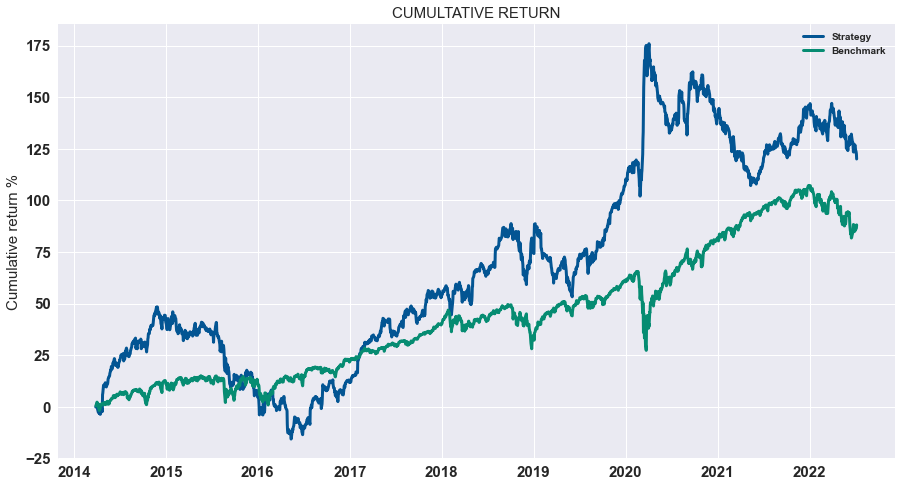

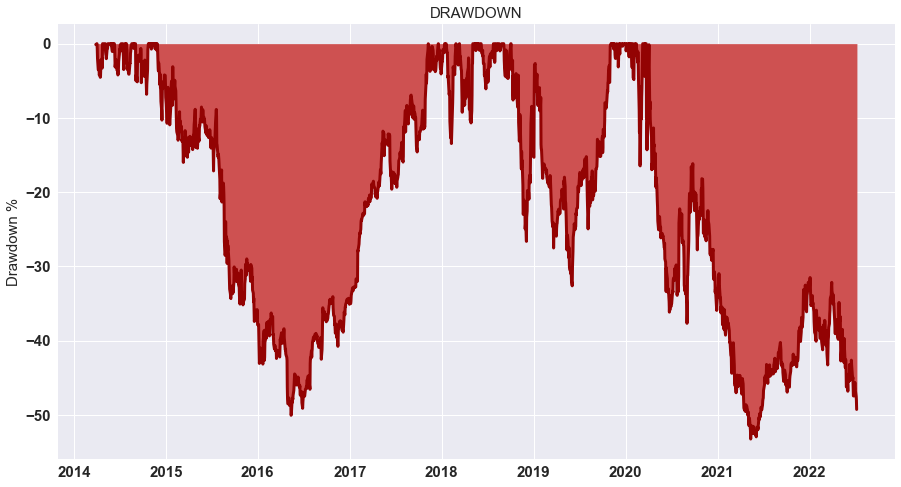

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.039 	 Alpha: 14.1 %	     Sharpe: 0.503 	 Sortino: 0.735
  -----------------------------------------------------------------------------
    VaR: 52.42 %	 cVaR: 62.25 % 	     VaR/cVaR: 1.188 	 drawdown: 53.25 %
  -----------------------------------------------------------------------------


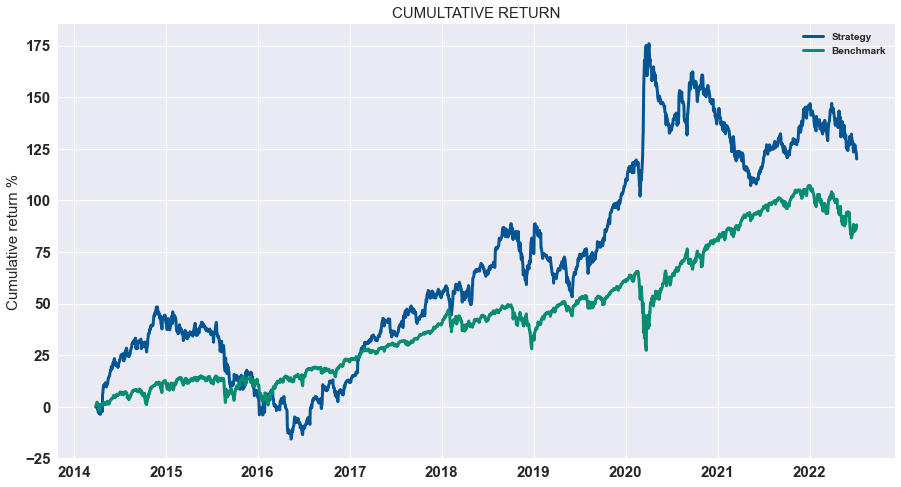

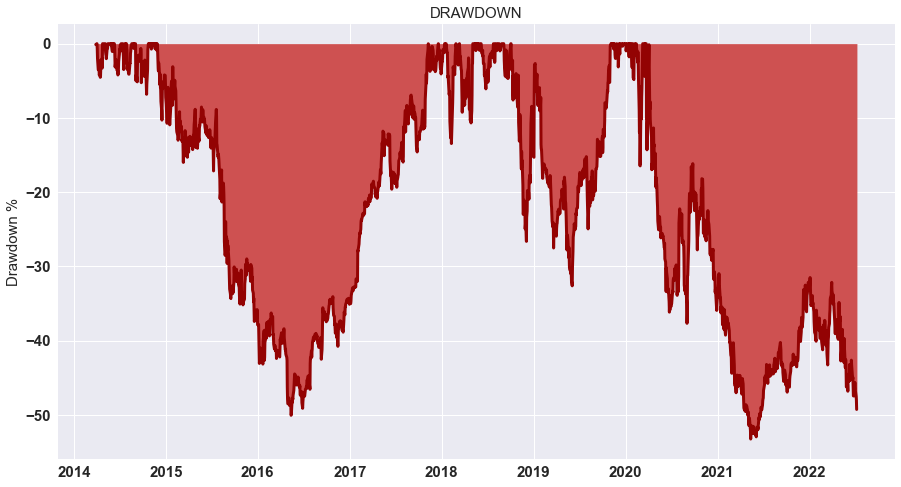

In [91]:
# Import the class
from sklearn.tree import DecisionTreeClassifier

# Initialize the class
dtc = DecisionTreeClassifier(max_depth=6)

# Fit the model
dtc.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = dtc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.113 	 Alpha: -14.54 %	     Sharpe: -0.545 	 Sortino: -0.754
  -----------------------------------------------------------------------------
    VaR: 83.07 %	 cVaR: 92.6 % 	     VaR/cVaR: 1.115 	 drawdown: 84.81 %
  -----------------------------------------------------------------------------


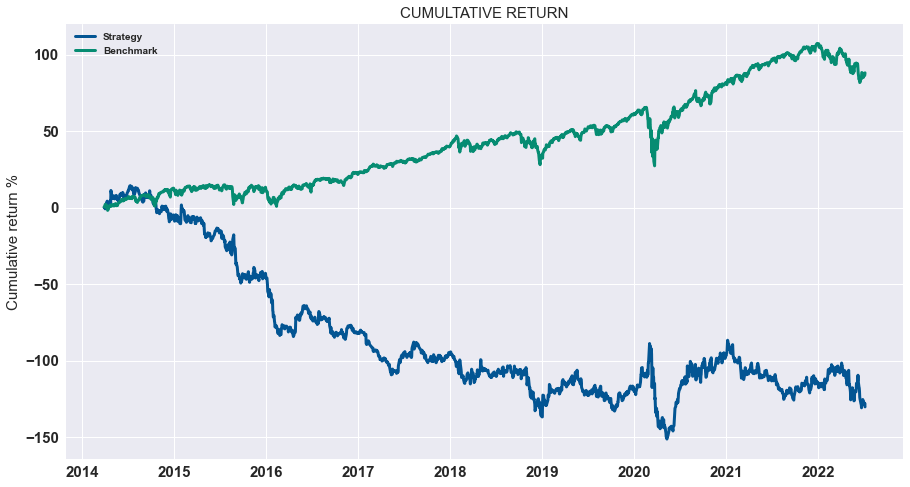

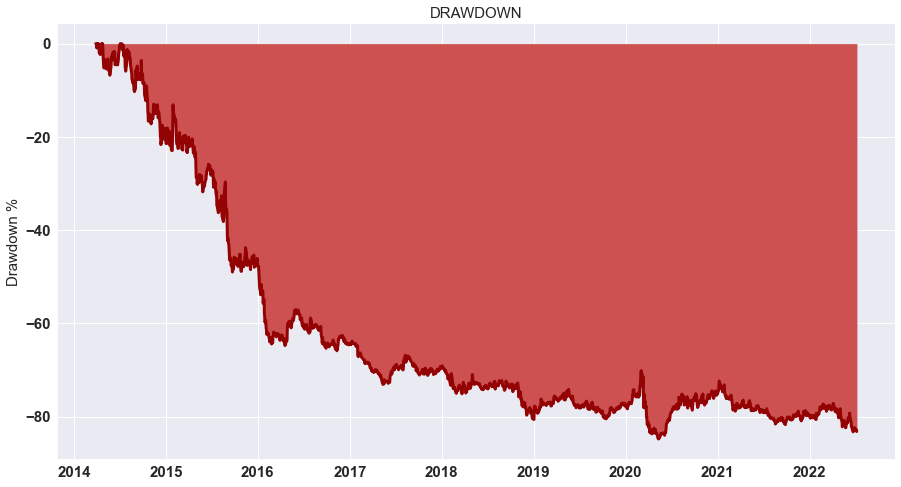

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.131 	 Alpha: -12.77 %	     Sharpe: -0.49 	 Sortino: -0.677
  -----------------------------------------------------------------------------
    VaR: 81.5 %	 cVaR: 91.02 % 	     VaR/cVaR: 1.117 	 drawdown: 82.61 %
  -----------------------------------------------------------------------------


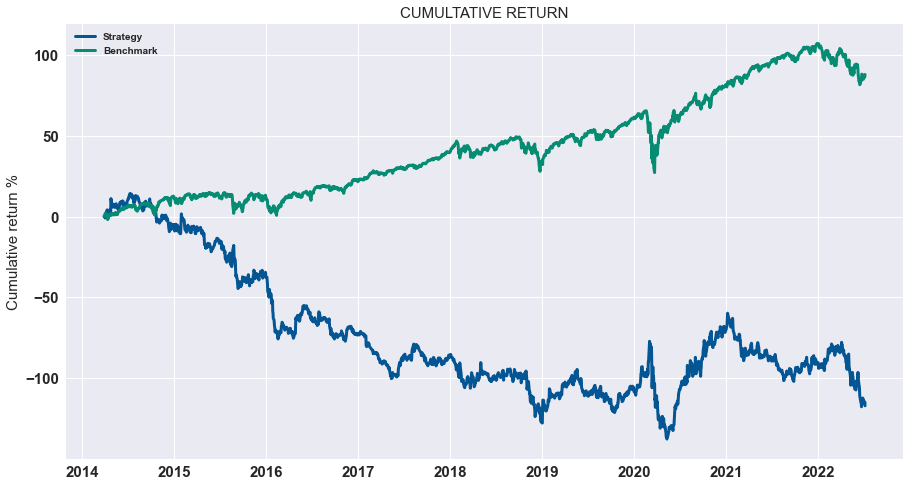

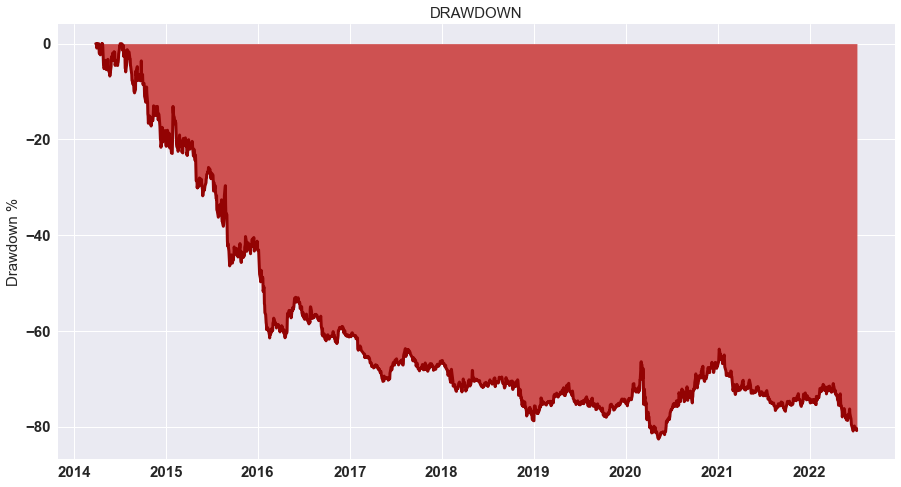

In [92]:
# Initialize the class
trc_no_maxdepth = DecisionTreeClassifier()

# Fit the model
trc_no_maxdepth.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = trc_no_maxdepth.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.1.2. Decision tree regressor

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.191 	 Alpha: 17.46 %	     Sharpe: 1.046 	 Sortino: 1.419
  -----------------------------------------------------------------------------
    VaR: 36.99 %	 cVaR: 46.5 % 	     VaR/cVaR: 1.257 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


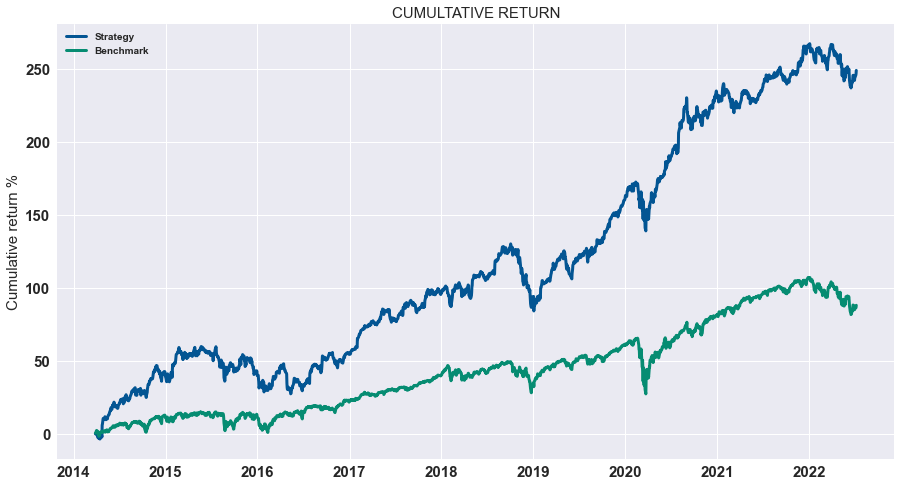

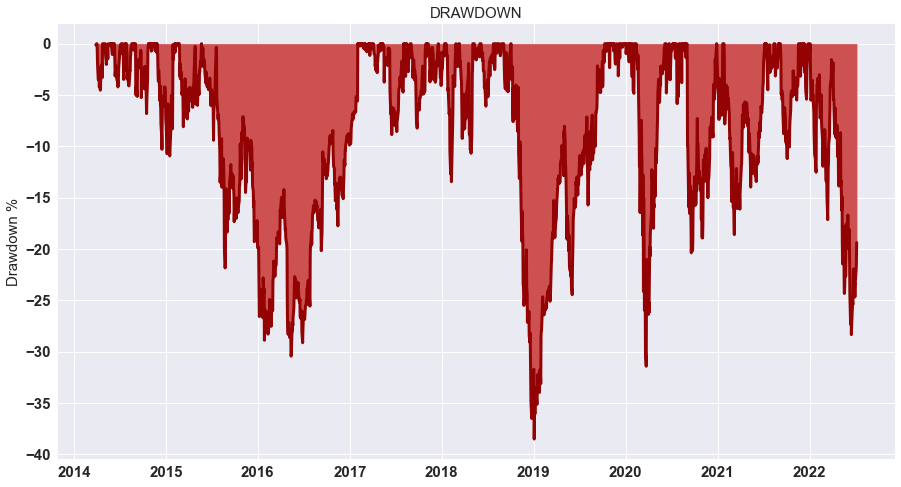

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.191 	 Alpha: 17.46 %	     Sharpe: 1.046 	 Sortino: 1.419
  -----------------------------------------------------------------------------
    VaR: 36.99 %	 cVaR: 46.5 % 	     VaR/cVaR: 1.257 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


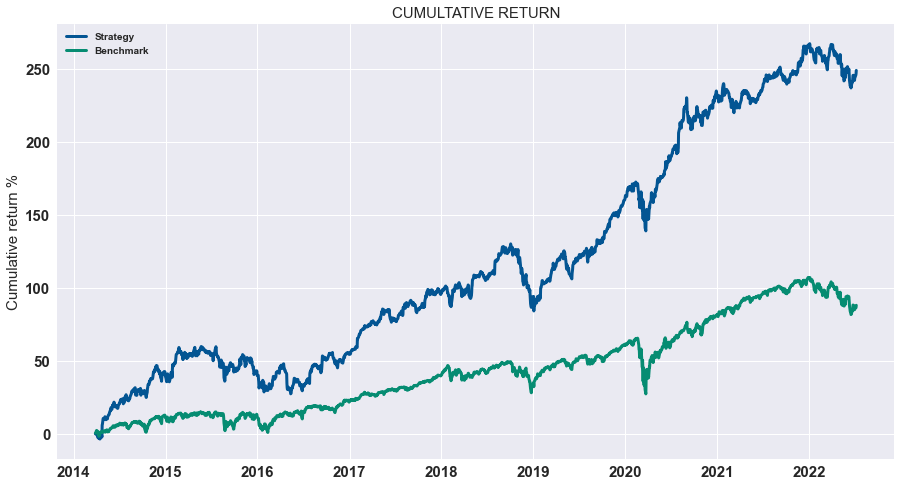

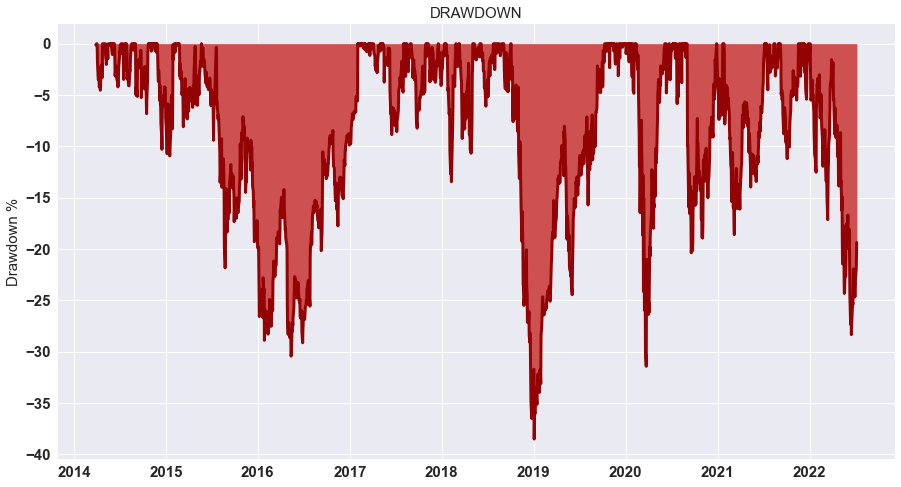

In [93]:
# Import the class
from sklearn.tree import DecisionTreeRegressor

# Initialize the class
dtr = DecisionTreeRegressor(max_depth=6)

# Fit the model
dtr.fit(X_train, y_train_reg)

# Create predictions for the whole dataset
df["prediction"] = dtr.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.1.3. Optimize the hyperparameters

In [94]:
# Import the class
from sklearn.model_selection import GridSearchCV

# Create the model
dtr = DecisionTreeRegressor()

# Choose a list of parameters
param = {"max_depth": [3,6,15]}

# Create the GridSearch
model = GridSearchCV(dtr, param_grid=param, cv=3,)

# Train the model
model.fit(X_train.values, y_train_reg.values)

# Print best model
model.best_estimator_

DecisionTreeRegressor(max_depth=3)

DecisionTreeRegressor(max_depth=3)

In [95]:
# Import the function
from sklearn.metrics import make_scorer

# RETURNS
# Create returns criterion
def returns(y, y_pred):
    return np.sum(np.sign(y_pred) * y)

# Transform criterion into a metric
returns_metric  = make_scorer(returns, greater_is_better=True)

# SHARPE
# Create sharpe criterion
def sharpe(y, y_pred):
    r = np.sign(y_pred) * y
    return np.mean(r) / np.std(r)

# Transform criterion into a metric
sharpe_metric  = make_scorer(sharpe, greater_is_better=True)


In [96]:
model = GridSearchCV(dtr, param_grid=param, scoring=sharpe_metric, cv=3)

model.fit(X_train.values, y_train_reg.values)

model.best_estimator_

DecisionTreeRegressor(max_depth=3)

DecisionTreeRegressor(max_depth=3)

### 10.2.1. Random forest classifier

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.05 	 Alpha: -0.04 %	     Sharpe: 0.017 	 Sortino: 0.023
  -----------------------------------------------------------------------------
    VaR: 67.04 %	 cVaR: 76.74 % 	     VaR/cVaR: 1.145 	 drawdown: 70.27 %
  -----------------------------------------------------------------------------


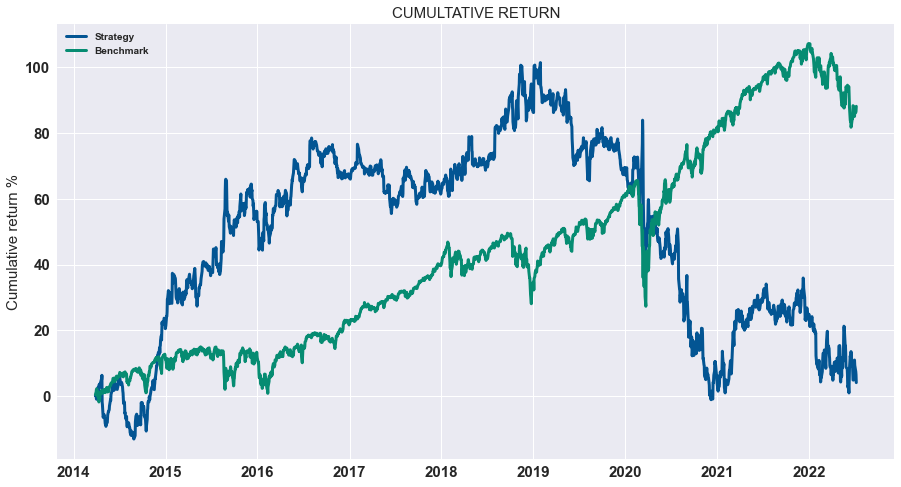

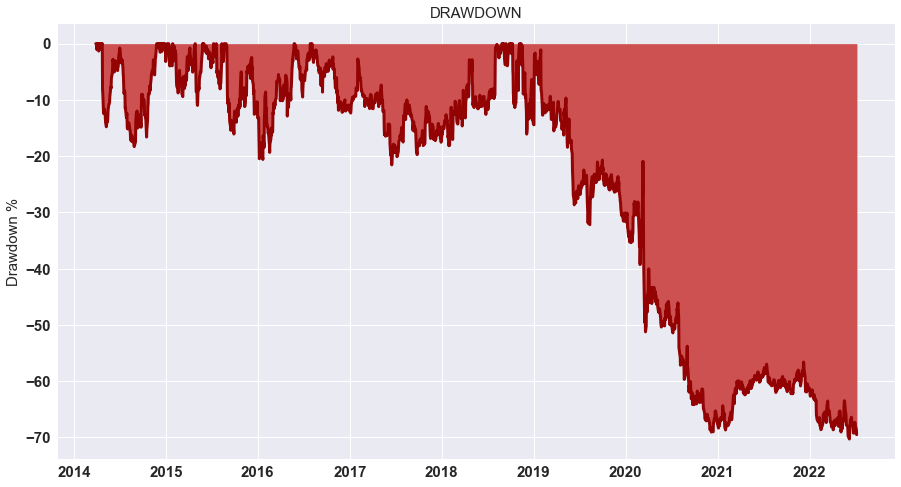

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.024 	 Alpha: -2.69 %	     Sharpe: -0.084 	 Sortino: -0.115
  -----------------------------------------------------------------------------
    VaR: 69.98 %	 cVaR: 79.67 % 	     VaR/cVaR: 1.139 	 drawdown: 73.47 %
  -----------------------------------------------------------------------------


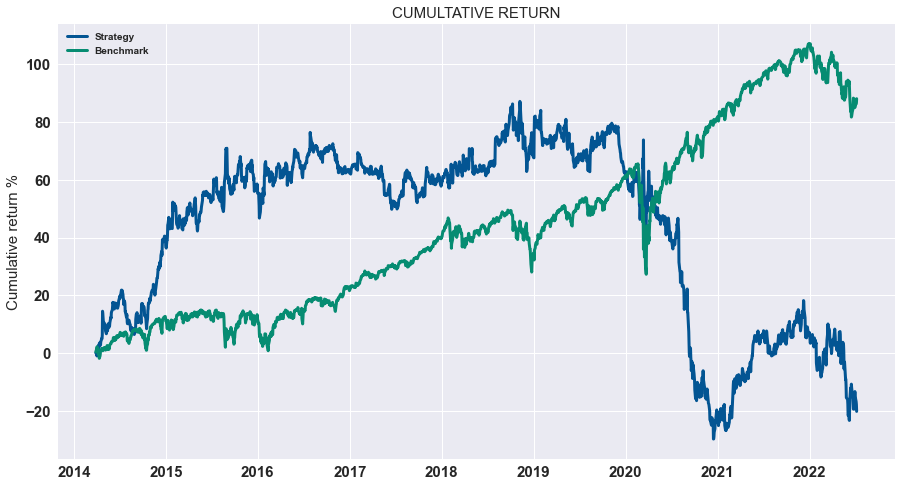

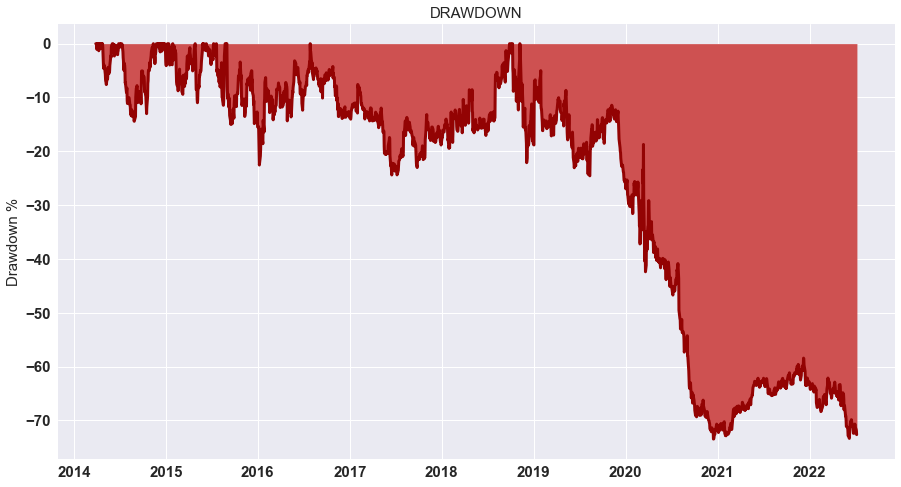

In [97]:
# Import the class
from sklearn.ensemble import RandomForestClassifier

# Initialize the class
lr = RandomForestClassifier()

# Fit the model
lr.fit(X_train, y_train_cla)

# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.026 	 Alpha: 533.07 %	     Sharpe: 15.464 	 Sortino: nan
  -----------------------------------------------------------------------------
    VaR: -452.47 %	 cVaR: -440.95 % 	     VaR/cVaR: 0.975 	 drawdown: 0.66 %
  -----------------------------------------------------------------------------


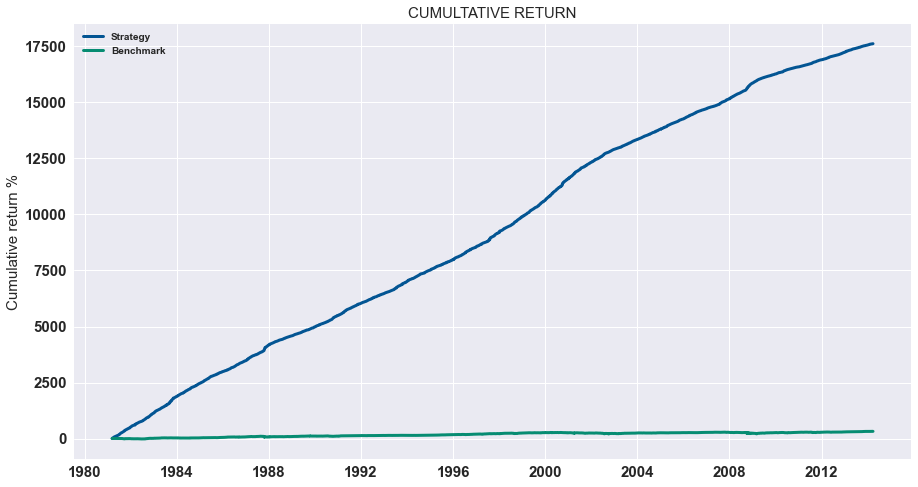

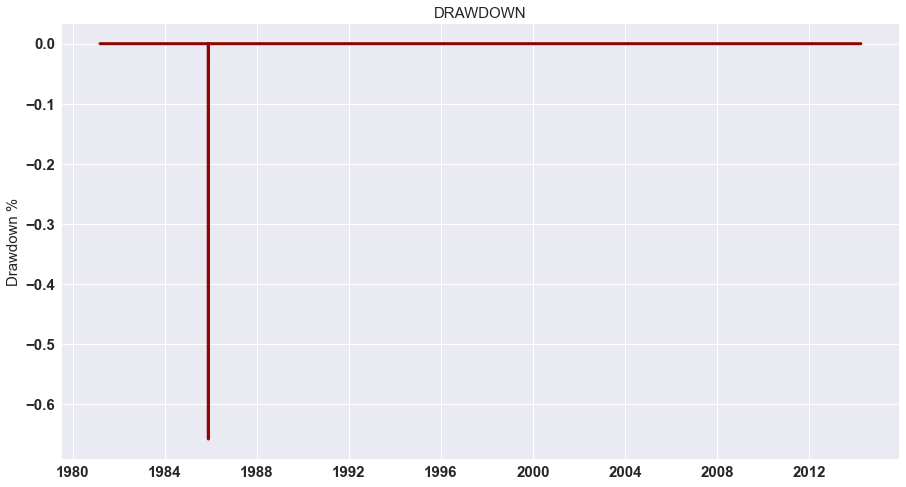

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.026 	 Alpha: 533.07 %	     Sharpe: 15.464 	 Sortino: nan
  -----------------------------------------------------------------------------
    VaR: -452.47 %	 cVaR: -440.95 % 	     VaR/cVaR: 0.975 	 drawdown: 0.66 %
  -----------------------------------------------------------------------------


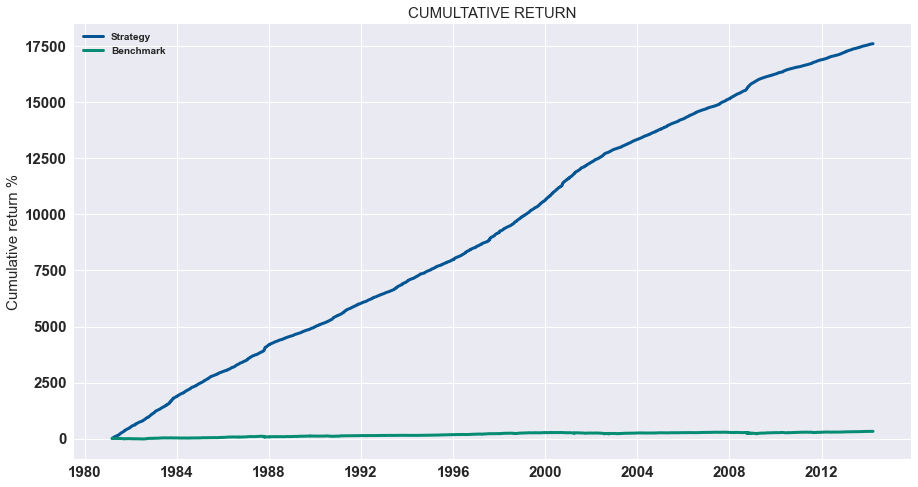

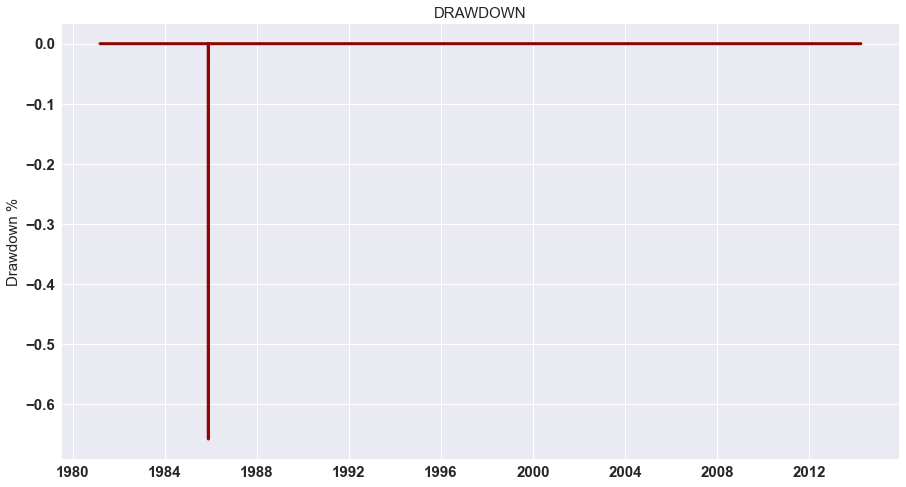

In [98]:
# Highlight the overfitting
backtest_dynamic_portfolio(df["strategy"].iloc[:split])

### 10.2.2. Random forest regressor

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.082 	 Alpha: 18.99 %	     Sharpe: 1.059 	 Sortino: 1.42
  -----------------------------------------------------------------------------
    VaR: 36.78 %	 cVaR: 46.13 % 	     VaR/cVaR: 1.254 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


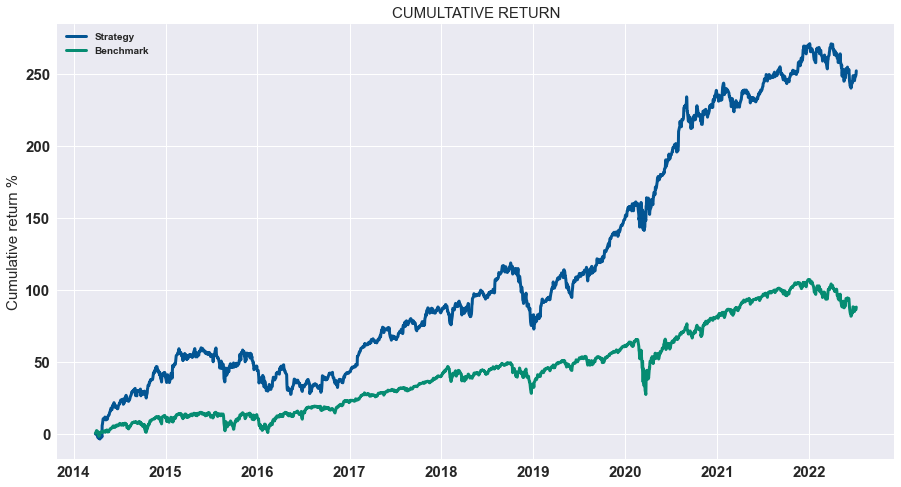

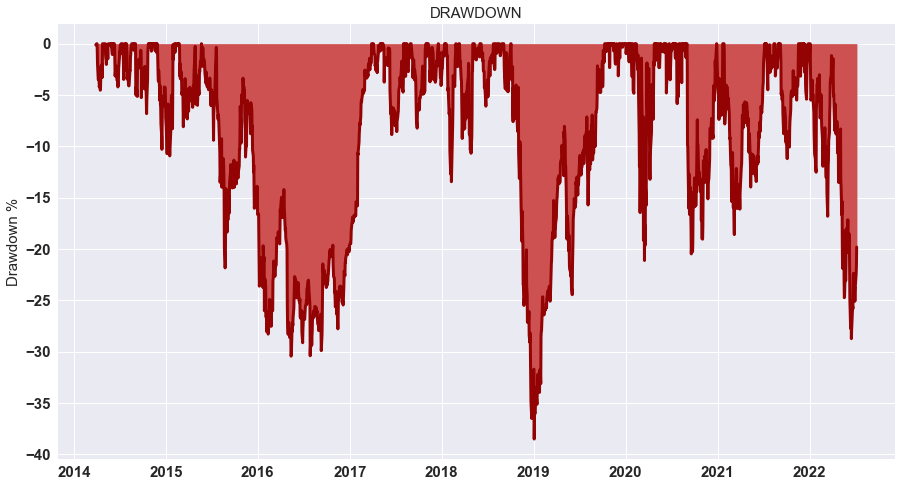

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.08 	 Alpha: 19.48 %	     Sharpe: 1.075 	 Sortino: 1.442
  -----------------------------------------------------------------------------
    VaR: 36.32 %	 cVaR: 45.66 % 	     VaR/cVaR: 1.257 	 drawdown: 35.33 %
  -----------------------------------------------------------------------------


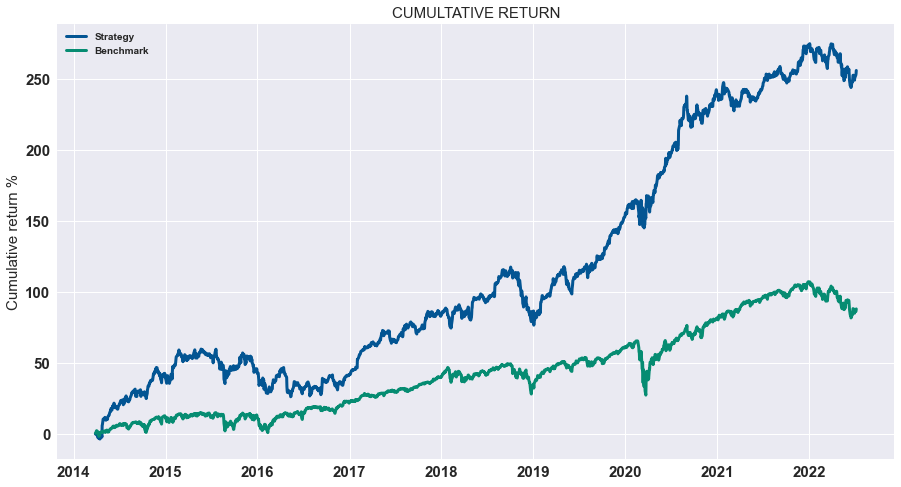

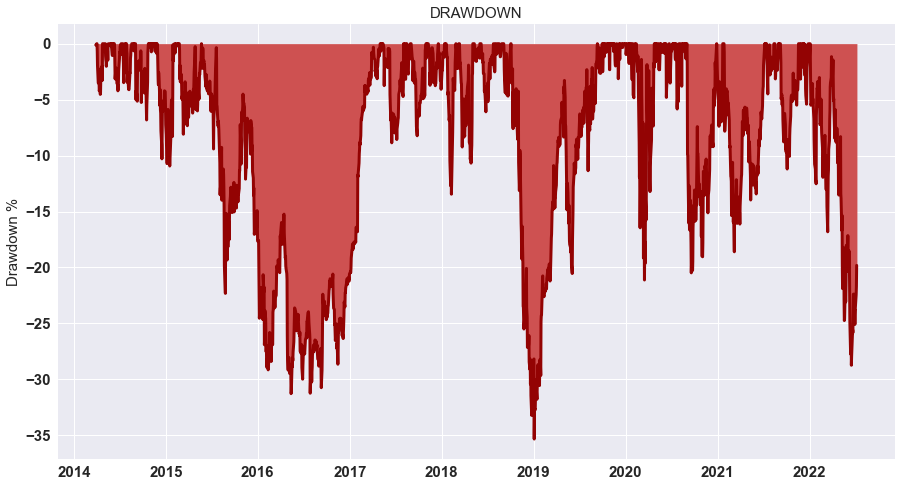

In [99]:
np.random.seed(15)
# Import the class
from sklearn.ensemble import RandomForestRegressor

# Initialize the class
lr = RandomForestRegressor(max_depth=6)

# Fit the model
lr.fit(X_train, y_train_reg)

# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.2.3. Optimize the hyperparameters

In [100]:
# Import the class
from sklearn.model_selection import GridSearchCV

# Create the model
dtr = RandomForestRegressor()

# Choose a list of parameters
param = {"max_depth": [3,6,15], "n_estimators": [50, 100, 150]}


# Import the function
from sklearn.metrics import make_scorer

# SHARPE
# Create sharpe criterion
def sharpe(y, y_pred):
    r = np.sign(y_pred) * y
    return np.mean(r) / np.std(r)

# Transform criterion into a metric
sharpe_metric  = make_scorer(sharpe, greater_is_better=True)


model = GridSearchCV(dtr, param_grid=param, scoring=sharpe_metric, cv=3)

model.fit(X_train.values, y_train_reg.values)

model.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=150)

RandomForestRegressor(max_depth=3, n_estimators=150)

Date
2022-07-07    0.00112
Name: prediction, dtype: float64
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.177 	 Alpha: 17.82 %	     Sharpe: 1.053 	 Sortino: 1.429
  -----------------------------------------------------------------------------
    VaR: 37.35 %	 cVaR: 47.27 % 	     VaR/cVaR: 1.266 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


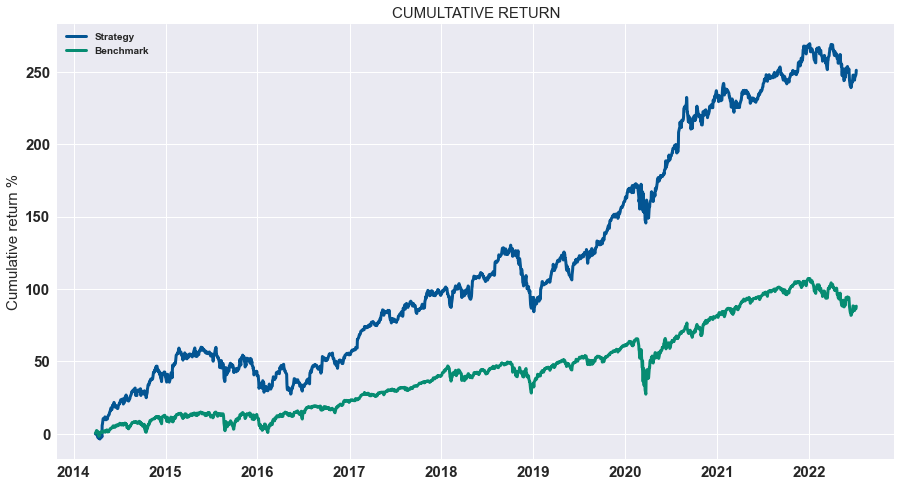

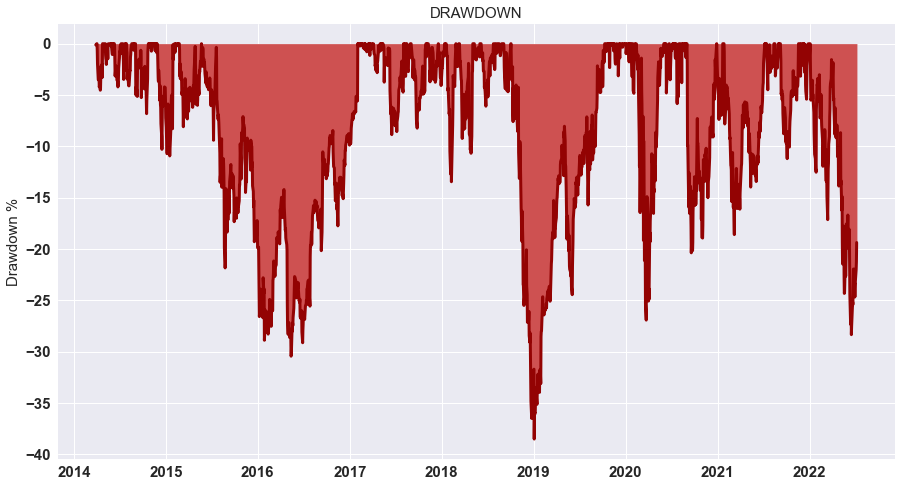

Date
2022-07-07    0.001121
Name: prediction, dtype: float64
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.177 	 Alpha: 17.82 %	     Sharpe: 1.053 	 Sortino: 1.429
  -----------------------------------------------------------------------------
    VaR: 37.35 %	 cVaR: 47.27 % 	     VaR/cVaR: 1.266 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


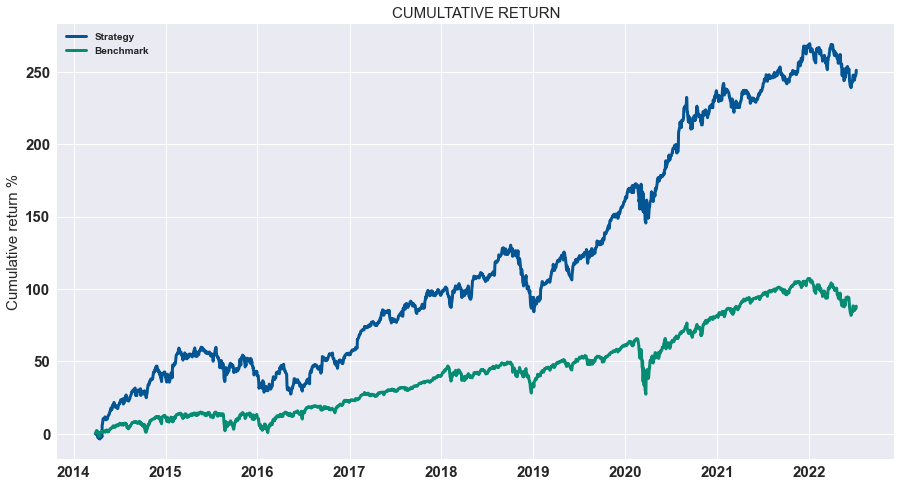

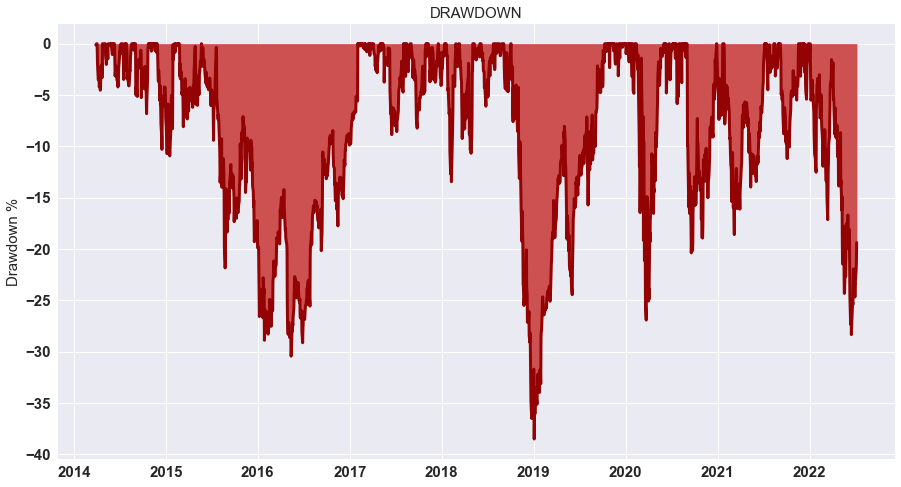

In [101]:
np.random.seed(15)
# Initialize the class
rfc = RandomForestRegressor(n_estimators=150, max_depth=3)

# Fit the model
rfc.fit(X_train, y_train_reg)
# Create predictions for the whole dataset
df["prediction"] = rfc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

print(df.prediction.tail(1))

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.243 	 Alpha: 21.12 %	     Sharpe: 0.821 	 Sortino: 1.185
  -----------------------------------------------------------------------------
    VaR: 43.47 %	 cVaR: 53.22 % 	     VaR/cVaR: 1.224 	 drawdown: 57.76 %
  -----------------------------------------------------------------------------


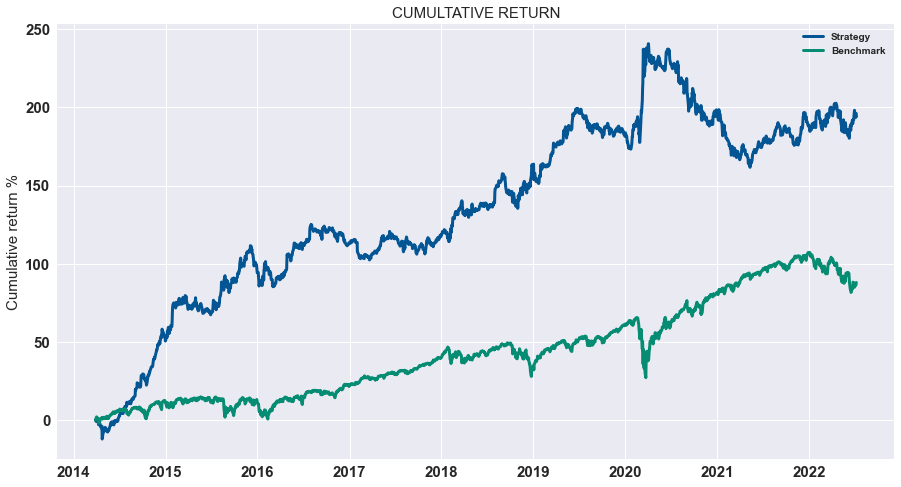

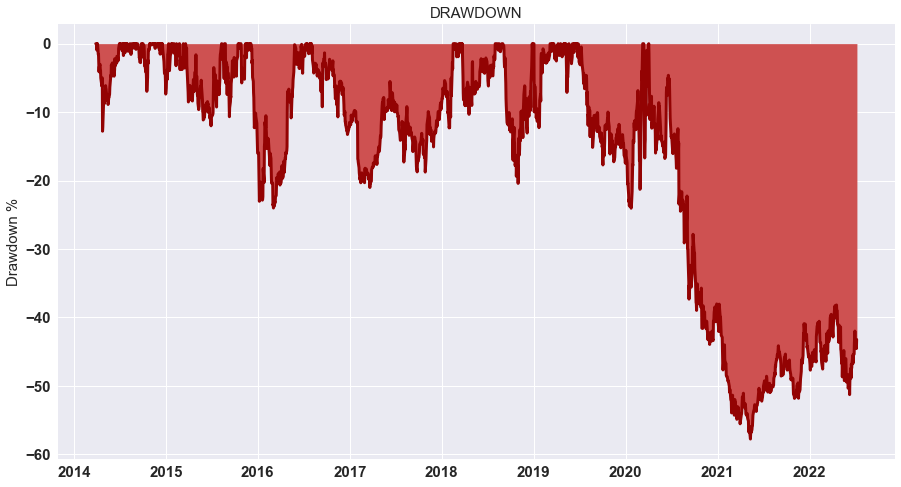

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.246 	 Alpha: 21.16 %	     Sharpe: 0.824 	 Sortino: 1.187
  -----------------------------------------------------------------------------
    VaR: 43.39 %	 cVaR: 53.14 % 	     VaR/cVaR: 1.225 	 drawdown: 55.24 %
  -----------------------------------------------------------------------------


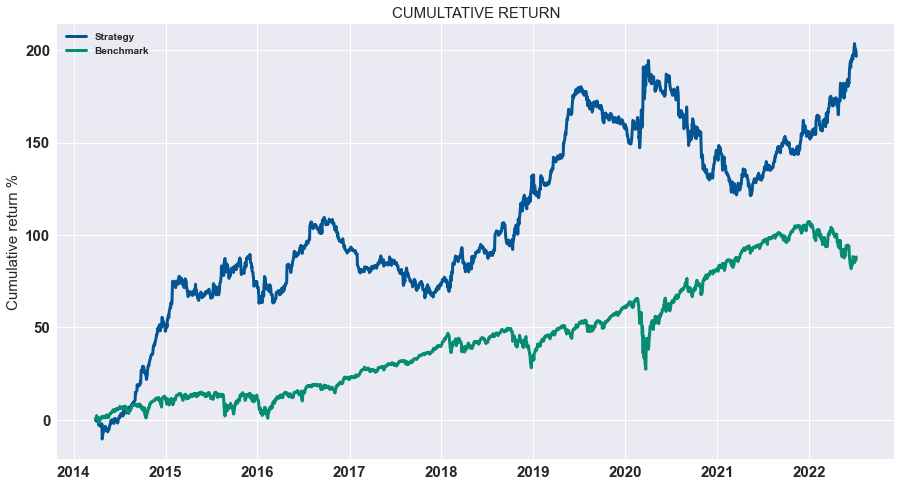

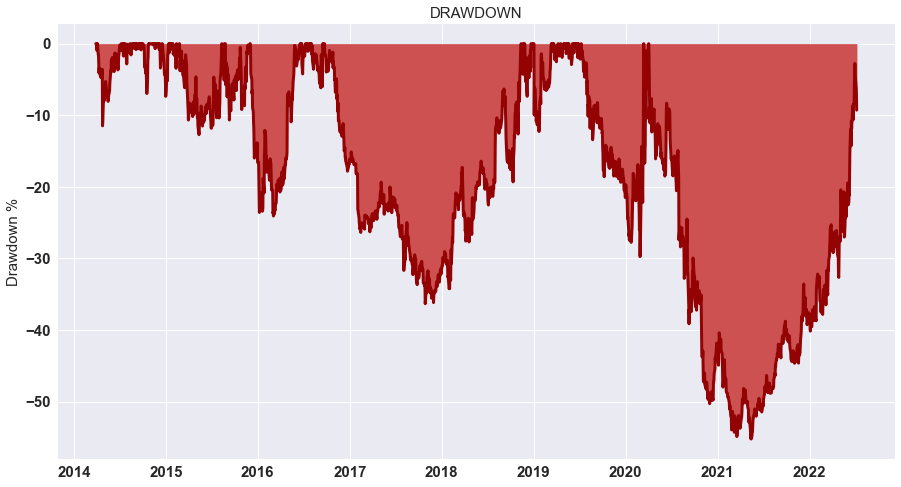

In [102]:
# Initialize the class
rfc = RandomForestRegressor()

# Fit the model
rfc.fit(X_train, y_train_reg)
# Create predictions for the whole dataset
df["prediction"] = rfc.predict(np.concatenate((X_train,X_test),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.3.1. Voting method

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -1.191 	 Alpha: -17.46 %	     Sharpe: -1.046 	 Sortino: -1.469
  -----------------------------------------------------------------------------
    VaR: 97.46 %	 cVaR: 106.81 % 	     VaR/cVaR: 1.096 	 drawdown: 95.18 %
  -----------------------------------------------------------------------------


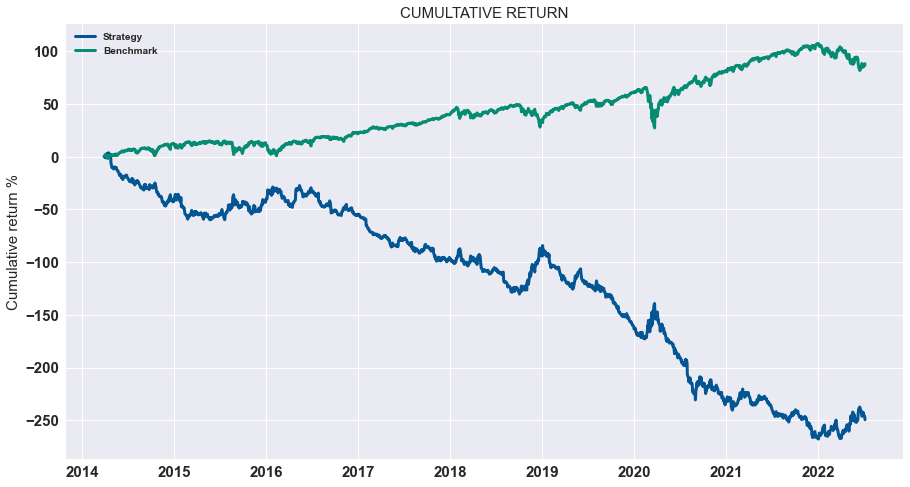

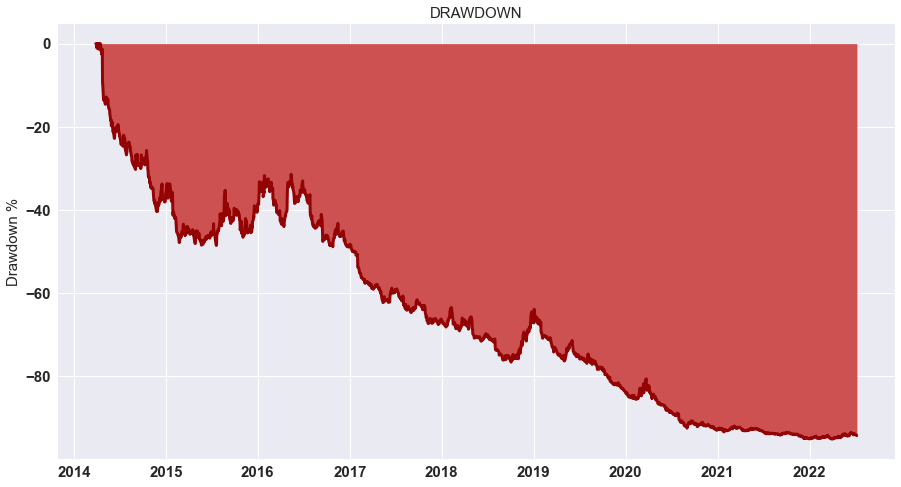

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -1.191 	 Alpha: -17.46 %	     Sharpe: -1.046 	 Sortino: -1.469
  -----------------------------------------------------------------------------
    VaR: 97.46 %	 cVaR: 106.81 % 	     VaR/cVaR: 1.096 	 drawdown: 95.18 %
  -----------------------------------------------------------------------------


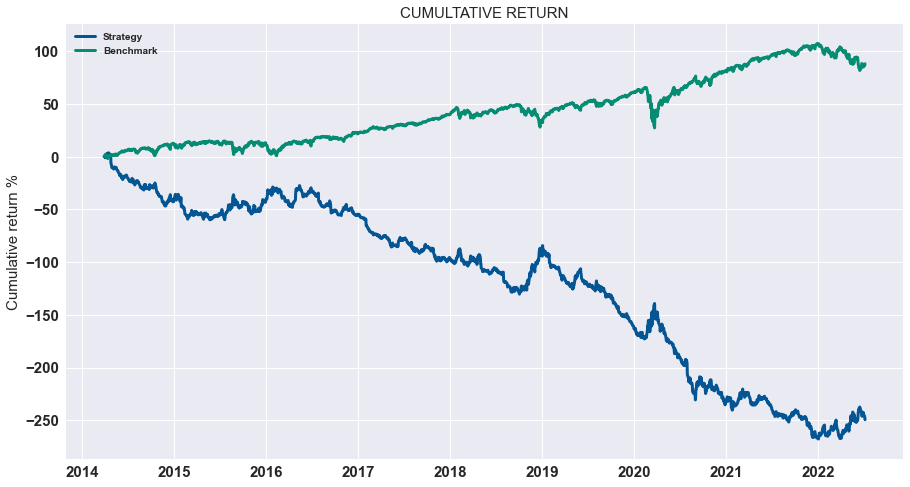

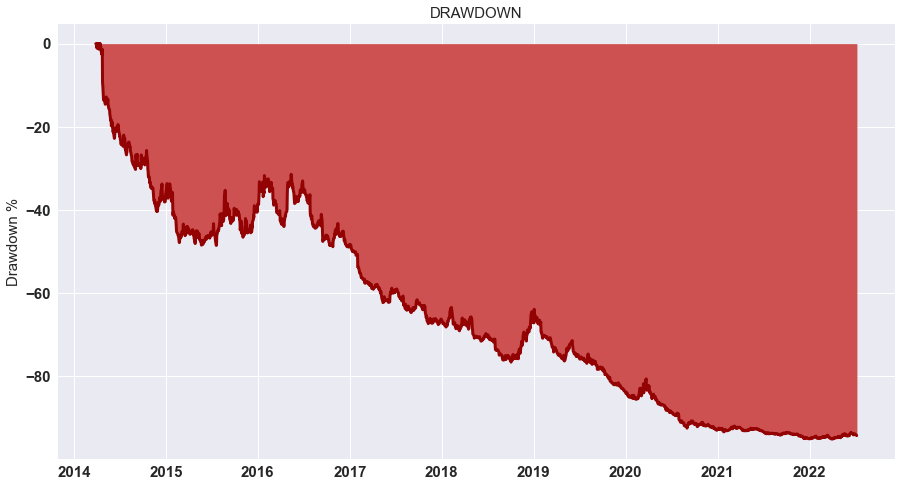

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, VotingRegressor

# Intitialize the estimators
clf1 = LinearRegression()
clf2 = RandomForestRegressor(n_estimators=150, max_depth=3)
clf3 = SVR(epsilon=1.5)

# Create the ensemble method
eclf1 = VotingRegressor(estimators=[
        ('lr', clf1), ('rf', clf2), ("svc", clf3)])

# Train the method
eclf1.fit(X_train, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = eclf1.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
np.random.seed(15)
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.3.2. Bagging method
Warnings: here, we take the scaled sets again because it is necessary for the SVMs.

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -1.191 	 Alpha: -17.46 %	     Sharpe: -1.046 	 Sortino: -1.469
  -----------------------------------------------------------------------------
    VaR: 97.38 %	 cVaR: 107.44 % 	     VaR/cVaR: 1.103 	 drawdown: 95.18 %
  -----------------------------------------------------------------------------


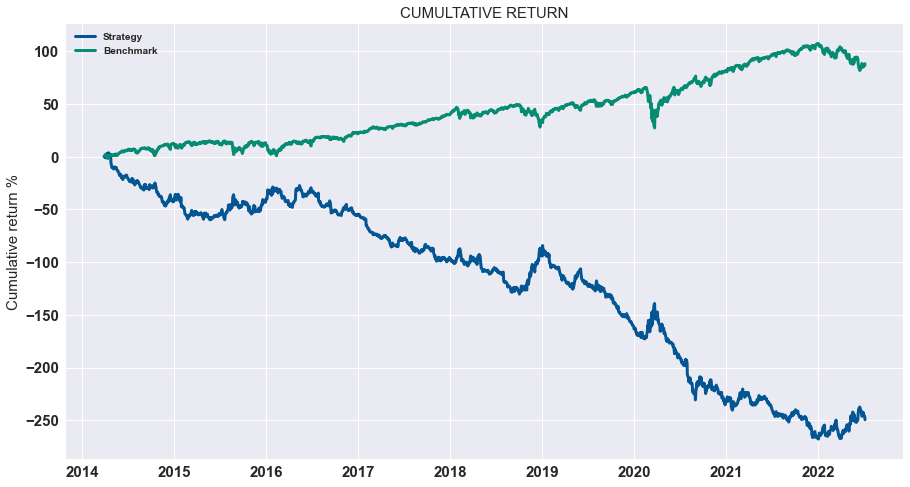

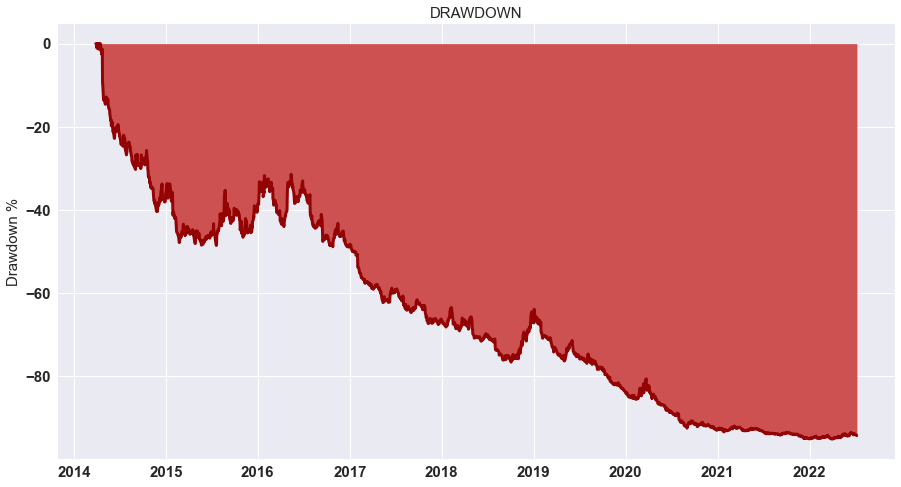

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -1.191 	 Alpha: -17.46 %	     Sharpe: -1.046 	 Sortino: -1.469
  -----------------------------------------------------------------------------
    VaR: 97.38 %	 cVaR: 107.44 % 	     VaR/cVaR: 1.103 	 drawdown: 95.18 %
  -----------------------------------------------------------------------------


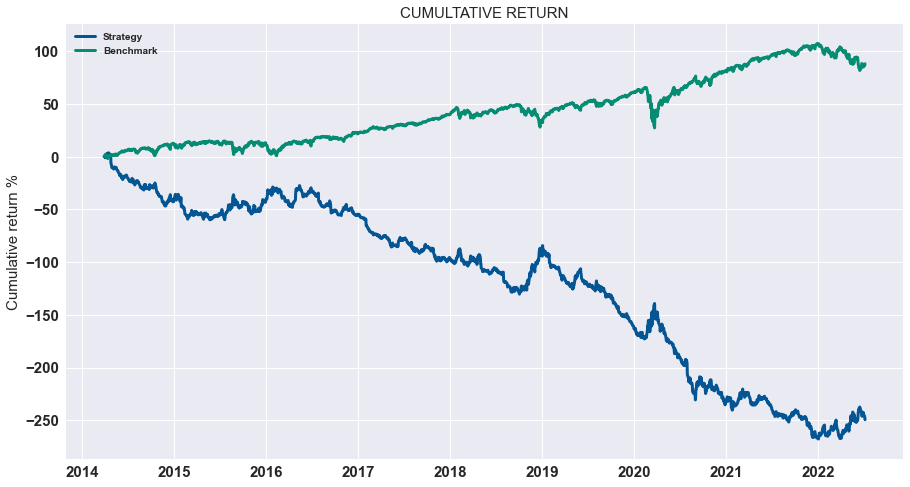

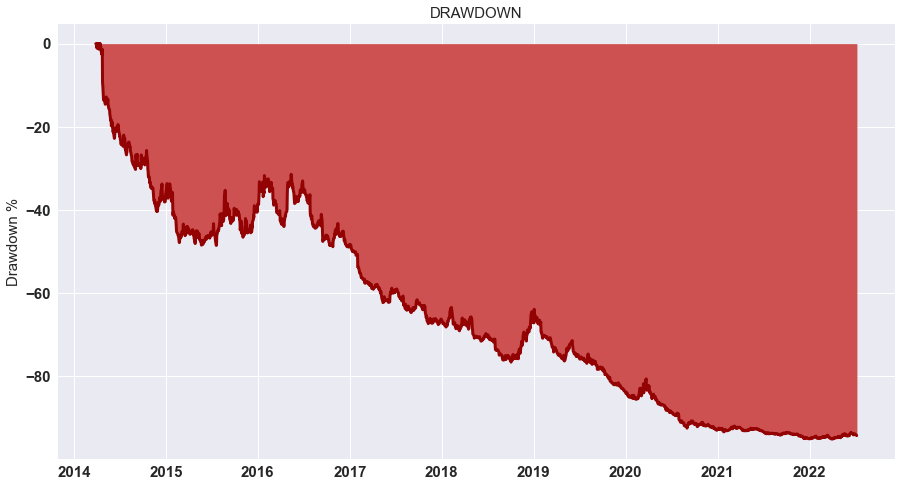

In [104]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

# Initialize the bagging
bag_reg = BaggingRegressor(SVR(epsilon=1.5), n_estimators=150)

# Train the method
bag_reg.fit(X_train_scaled, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = bag_reg.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 10.3.3. Stacking method

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.191 	 Alpha: 17.46 %	     Sharpe: 1.046 	 Sortino: 1.419
  -----------------------------------------------------------------------------
    VaR: 36.27 %	 cVaR: 46.06 % 	     VaR/cVaR: 1.27 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


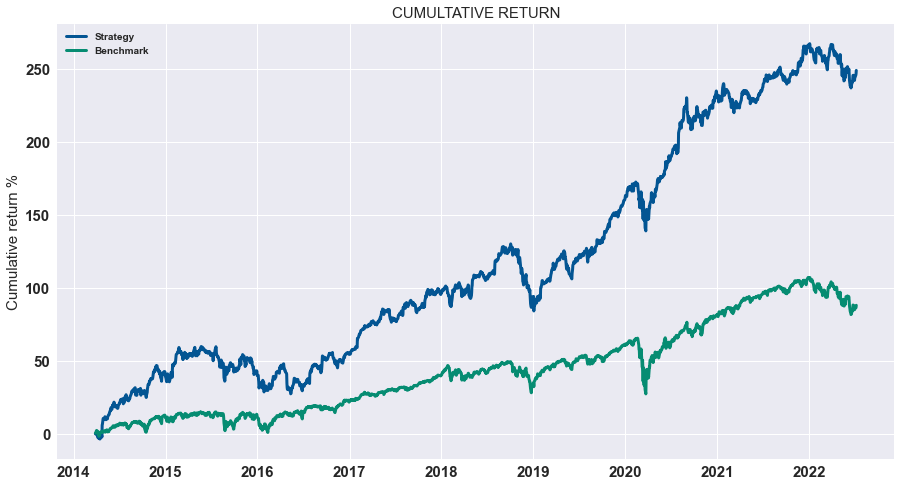

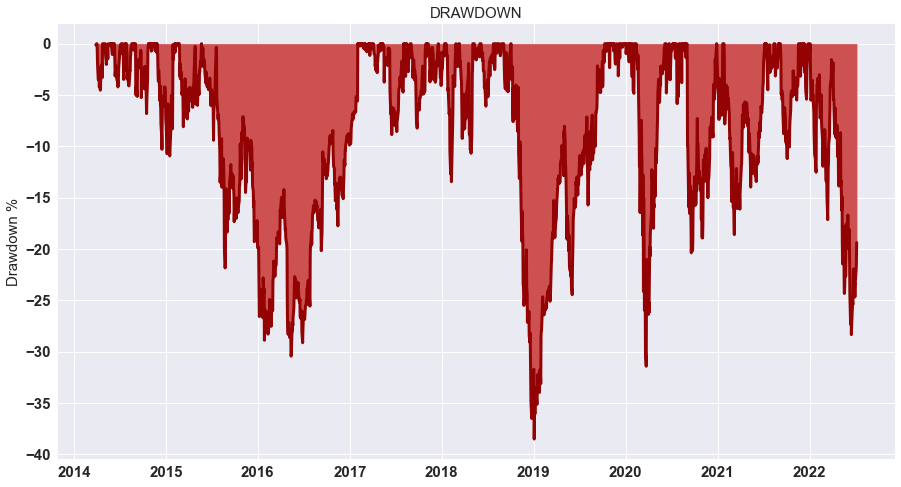

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.191 	 Alpha: 17.46 %	     Sharpe: 1.046 	 Sortino: 1.419
  -----------------------------------------------------------------------------
    VaR: 36.27 %	 cVaR: 46.06 % 	     VaR/cVaR: 1.27 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


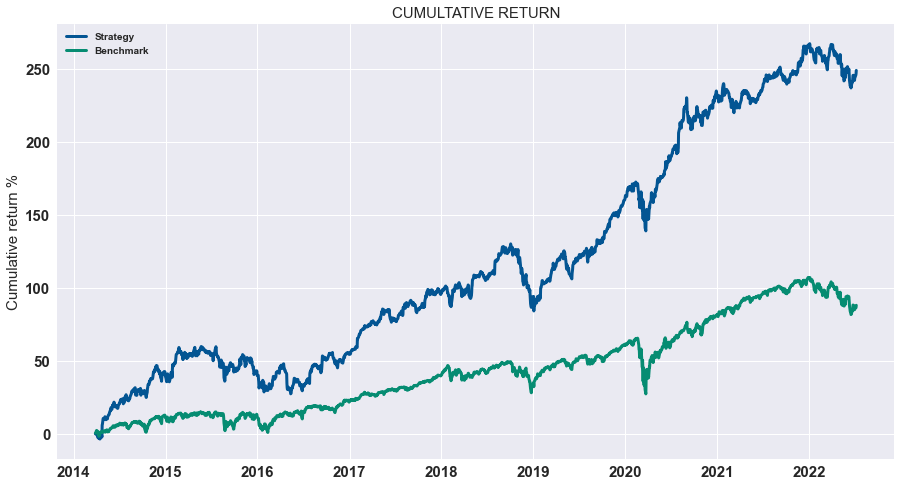

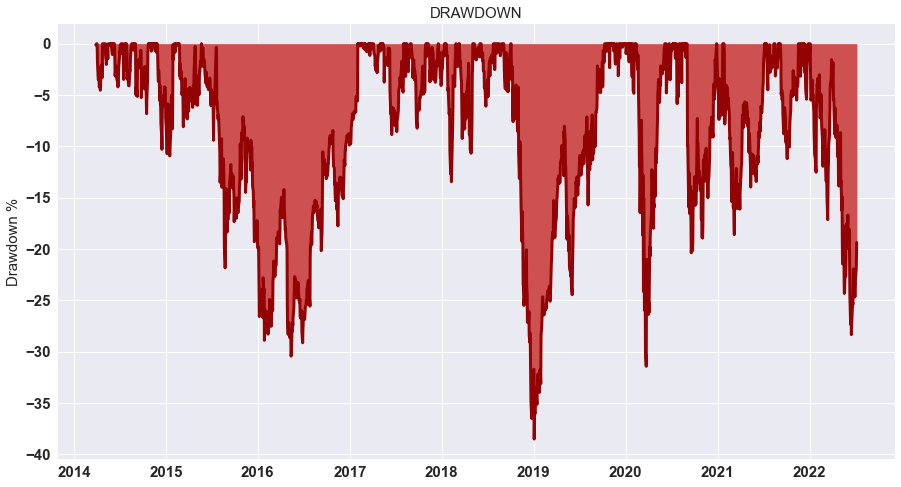

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Intitialize the estimators
clf1 = LinearRegression()
clf2 = RandomForestRegressor(n_estimators=150, max_depth=3)
clf3 = SVR(epsilon=1.5)

# Create the ensemble method
eclf1 = StackingRegressor(estimators=[
        ('lr', clf1), ('rf', clf2), ("svc", clf3)])

# Train the method
eclf1.fit(X_train, y_train_reg)


# Create predictions for the whole dataset
df["prediction"] = eclf1.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])